# About the Data

This notebook covers the exploration of data used in this project. Prior to putting this together, the following project files were run to generate the data:

* 1extract_candidate_tweets.py (*requires Twitter api key*)
* 1extract_noncandidate_tweets.py (*requires Twitter api key*)
* 2transform_tweets.py



In [194]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

# tweets data set
fname_tweets = 'data/data.csv'
tweets = pd.read_csv(fname_tweets)
# people data set
fname_people = 'data/People.xlsx' 
people = pd.read_excel(fname_people)
people = people.loc[people['Handle'].isin(tweets['handle'])]

/Users/laurenlawless/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


On May 24th, over 300,000 tweets respective to approximately 110 Twitter handles were extracted using the Tweepy library API. These were handles of pre-identified presidential candidates and sampling of non-candidates, mostly consisting of well-known political figures. This data was collected manually from publically available online sources such as https://ballotpedia.org. Other sources are cited in the project references.

In [195]:
people.head()

,Key,Name,Party,State,Governor,Senate,House,Ran 2020,2020 Join,2020 Drop,Ran 2016,2016 Join,2016 Drop,positions held,Handle,Looked for handle?
1,Abby Finkenauer-Iowa,Abby Finkenauer,Democratic,Iowa,0,0,1,0,NaT,NaT,0,NaT,NaT,1,RepFinkenauer,1.0
11,Al Green-Texas,Al Green,Democratic,Texas,0,0,1,0,NaT,NaT,0,NaT,NaT,1,RepAlGreen,1.0
37,Amy Klobuchar-Minnesota,Amy Klobuchar,Democratic,Minnesota,0,1,0,1,2019-02-10,2020-03-02,0,NaT,NaT,1,amyklobuchar,1.0
43,Andrew Yang-New York,Andrew Yang,Democratic,New York,0,0,0,1,2017-11-06,2020-02-11,0,NaT,NaT,0,AndrewYang,1.0
95,Ben Carson-Maryland,Ben Carson,Republican,Maryland,0,0,0,0,NaT,NaT,1,2015-05-03,2016-03-04,0,RealBenCarson,1.0


This data was used to determine which individuals announced their candidacy to run for President of the United States, the date of the announcement, and other attributes. Each observation represents dimensional data specific to a person; data includes both **candidates** and **non-candidates**. Among these attributes are included their political affiliations as shown in proportions below.

In [196]:
# are there any individuals that do not come from a government role?
from collections import Counter
roles = ['Governor','Senate','House']
Counter(people[roles].sum(axis=1))

Counter({1: 73, 0: 14, 2: 20, 3: 2})

There are 14 individuals in the data that did not hold a government role such as House, Senate, or Governor. Some of these have held municipal leadership roles and others came from the business roles.

In [197]:
print(people.loc[people[roles].sum(axis=1) == 0, 'Name'].values)

['Andrew Yang' 'Ben Carson' 'Bill de Blasio' 'Carly Fiorina'
 'Donald Trump' 'Julián Castro' 'Lawrence Lessig' 'Marianne Williamson'
 'Michael Bloomberg' 'Pete Buttigieg' 'Richard Ojeda' 'Rocky De La Fuente'
 'Tom Steyer' 'Wayne Messam']


In [198]:
print(people[people['Party']=='Independent'])

                        Key            Name        Party    State  Governor  \
109  Bernie Sanders-Vermont  Bernie Sanders  Independent  Vermont         0   

     Senate  House  Ran 2020  2020 Join  2020 Drop  Ran 2016  2016 Join  \
109       1      1         1 2019-02-19 2020-04-08         1 2015-04-30   

    2016 Drop  positions held         Handle  Looked for handle?  
109       NaT               2  BernieSanders                 1.0  


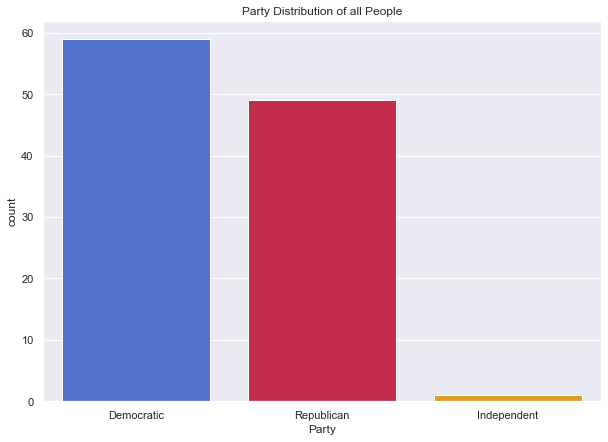

In [69]:
%matplotlib inline
sns.set(rc={'figure.figsize': (10,7)})
sns.countplot(x='Party', data=people, palette=['royalblue','crimson','orange'])
plt.title('Party Distribution of all People')
plt.show()

The majority of individuals in the data set either favored or were part of the Democratic Party followed by the Republican Party.

In addition to their party affiliation, other information includes the states in which they were primarily active. 

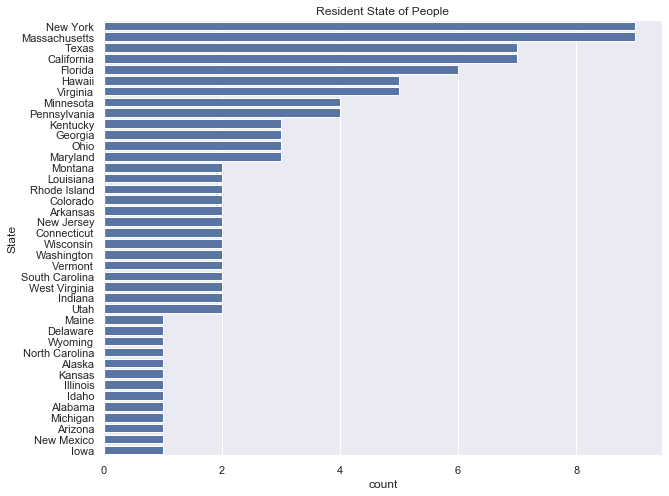

In [203]:
plt.figure(figsize=(10,8))
sns.countplot(y='State', data=people, order = people['State'].value_counts().index, color='C0')
#plot1 = sns.countplot(x='State', data=people)
#plot1 = plot1.set_xticklabels(plot1.get_xticklabels(), rotation=75, horizontalalignment='right')
plt.title('Resident State of People')
plt.show()

The top 5 states include Massachusetts, New York, California, Texas, and Florida. 

The following table shows an aggregation of key attributes by political party.

In [71]:
people.groupby('Party').sum()

,Governor,Senate,House,Ran 2020,Ran 2016,positions held,Looked for handle?
Party,,,,,,,
Democratic,12,17,29,28,5,58,59.0
Independent,0,1,1,1,1,2,1.0
Republican,18,14,27,5,17,59,49.0


The majority of those who ran in 2020 were Democrats, contrasting with a Republican majority in the 2016 campaign.

The following plot compares party affiliation to their primary government role (i.e. governer, senate, house).

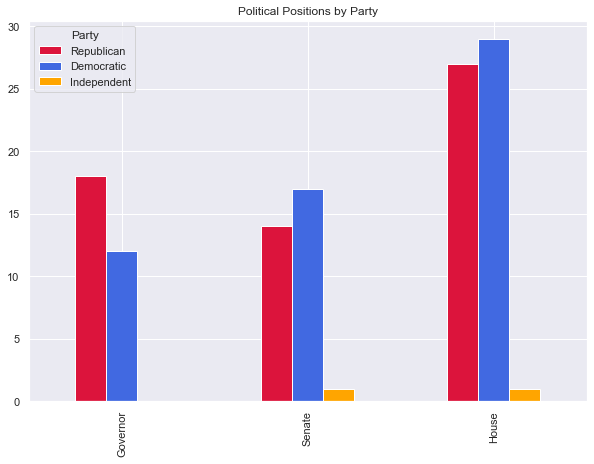

In [72]:
df_party = people.groupby('Party').sum()
df_party.reset_index(inplace=True)
subset = ['Party', 'Governor', 'Senate', 'House']
df_party = df_party[subset]
df_party = df_party.assign(tmp=df_party.sum(axis=1)).sort_values('tmp', ascending=False).drop('tmp',1)
#sns.set()
df_party.set_index('Party').T.plot(kind='bar', stacked=False, color = ['crimson','royalblue','orange'], figsize=(10,7))
plt.title('Political Positions by Party')
plt.show()

Most of the Democrats come from House or Senate roles, whereas Republicans come from House or Governor roles.

## Exploring Tweets Collected
The original tweets collected were formatted as JSON, filtered for english language, and subset to include just the text and creation dates.

In [73]:
from datetime import datetime
import time
import re
import numpy as np

def get_date(created_at):
    """Function to convert Twitter created_at to date format
    Argument:
        created_at {[str]} -- [raw tweet creation date time stamp]
    Returns:
        [str] -- [date e.g. '2020-04-18']
    """
    return time.strftime('%Y-%m-%d', time.strptime(created_at, '%a %b %d %H:%M:%S +0000 %Y'))

def get_date_time(tweetdate):
    """Function to convert twitter date to date time object
    
    Arguments:
        tweetdate {[str]} -- [twitter created at date]
    
    Returns:
        [datetime.datetime] -- [date time object]
    """
    
    dt = datetime.strptime(tweetdate, '%Y-%m-%d %H:%M:%S')
    return dt
# 2020-05-25 01:17:08

def clean_tweet(tweet):
    """Utility function to clean tweet text by removing links
    , hashtags, @mentions, and numbers
        using simple regex statements. Converts text to lowercase
    
    Arguments:
        tweet {[str]} -- [tweet text]
    
    Returns:
        [str] -- [clean tweet text]
    """    
    # remove links, hashtags, mentions, convert to lowercase
    pattern = re.compile("(\\w+:\\/\\/\\S+)|(#[A-Za-z0-9]+)|(@[A-Za-z]+[A-Za-z0-9-_]+)")
    tweet = re.sub(pattern, ' ', tweet).lower() 
    # remove numbers
    words = tweet.split()
    reformed = [word for word in words if not re.match('\\d', word)]
    tweet = ' '.join(reformed)
    out = ' '.join(tweet.split())
    return out    

In [74]:
print("There are {:d} tweets collected from {:d} Twitter handles".format(tweets.shape[0], len(tweets['handle'].unique())))

There are 308423 tweets collected from 109 Twitter handles


Altogether the tweets were created over a period of several years. The following shows this distribution.

In [76]:
tweets['created_at_date'] = tweets['created_at'].apply(get_date_time)
tweets['created_at_date'] = tweets['created_at_date'].dt.date

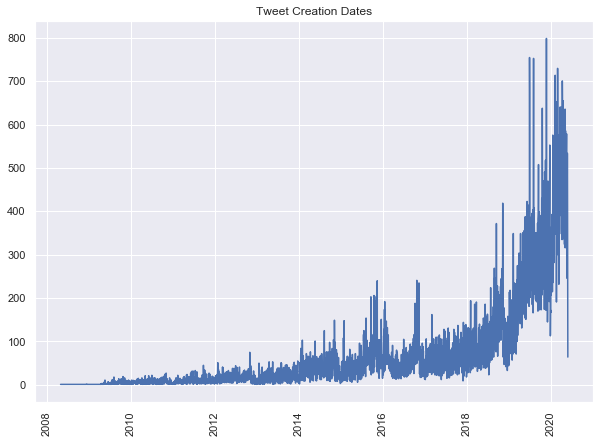

In [77]:
X,Y = np.unique(tweets['created_at_date'], return_counts=True)
plt.figure(figsize=(10,7))
plt.plot(X, Y)
plt.xticks(rotation=90)
plt.title("Tweet Creation Dates")
#plt.savefig('plt_tweet_time.png', bbox_inches = 'tight')
plt.show()

The tweets in this data set were mostly created between 2018 and 2020.

## Plot of Top 10 Candidates by Number of Tweets

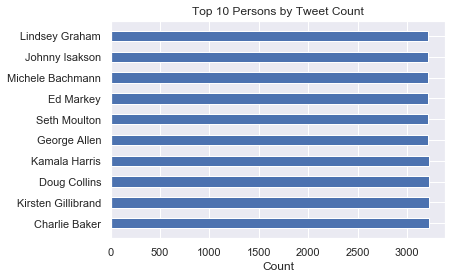

In [204]:
from collections import Counter
%matplotlib inline
users = tweets['user_name'].values
counter = Counter(users)
top10users = counter.most_common(10)
labels, values = zip(*top10users)
indexes = np.arange(len(labels))
width = 0.5 
plt.barh(indexes, values, width)
plt.yticks(indexes, labels)
plt.xlabel('Count')
plt.title("Top 10 Persons by Tweet Count")
#plt.savefig('plt_top_users.png', bbox_inches = 'tight')
plt.show()

In [79]:
tweet_counts = list(counter.values())
print("Mean tweet count: {:d}".format(int(np.mean(tweet_counts))))
print("Quantiles of tweet counts:", np.quantile(tweet_counts, [0, 0.25, 0.5, 0.75, 1]))

Mean tweet count: 2829
Quantiles of tweet counts: [   8. 3014. 3148. 3180. 3226.]


As a result of querying for all available tweets from each user's Twitter timeline, there are approximately 3000 tweets per individual.

## 2020 Candidates Tweet Counts

In [80]:
def plot_candidate_tweets(df, title):
    # get party respective to twitter handle; and colors
    partydict = {}
    for idx, row in df.iterrows():
        partydict[row['Handle']] = row['Party']
    handlelist = tweets.loc[tweets['handle'].isin(df['Handle']), 'handle'].tolist()
    counter = Counter(handlelist)
    labels, values = zip(*counter.items())
    values, labels = zip(*sorted(zip(values,labels)))
    colorlist = []
    for label in labels:
        if partydict[label] == 'Republican':
            val = 'crimson'
        elif partydict[label] == 'Democratic':
            val = 'royalblue'
        else: 
            val = 'orange'
        colorlist.append(val)
    # number of tweets by user
    indexes = np.arange(len(labels))
    plt.figure(figsize=(15,7))
    plt.bar(indexes, values, color = colorlist)
    plt.xticks(indexes + width * 0.5, labels)
    plt.xticks(rotation=90)
    plt.title(title)

## All Candidate Tweet Counts

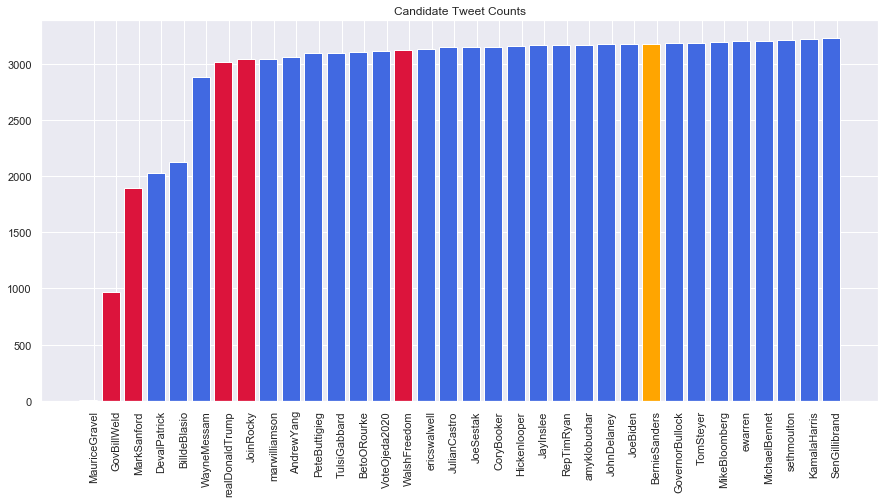

In [81]:
df = people[(people['Ran 2020'] == 1)]# | (people['Ran 2016'] == 1)]
plot_candidate_tweets(df, "Candidate Tweet Counts")

## All Non-Candidate Tweet Counts

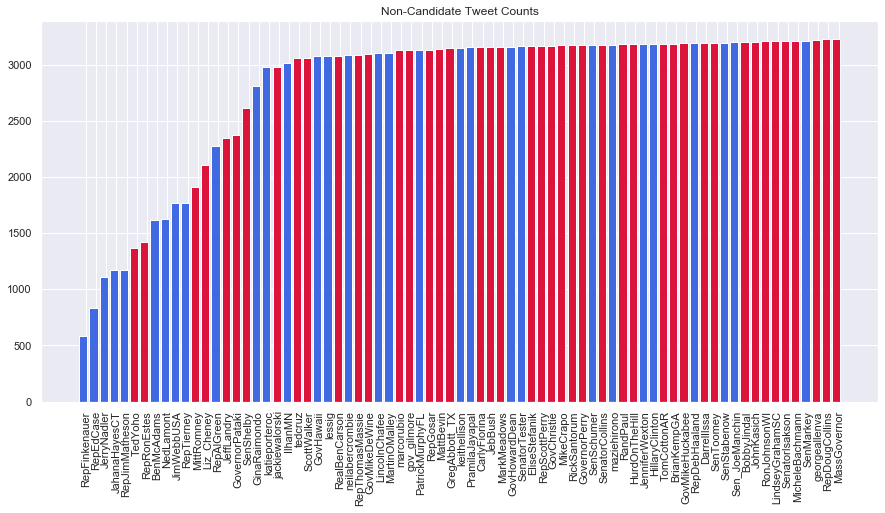

In [82]:
df = people[(people['Ran 2020'] == 0)]#(people['Ran 2016'] == 0) & 
plot_candidate_tweets(df, "Non-Candidate Tweet Counts")

There are more observations of candidate tweets than non-candidate tweets.

## Examine Tweet Text
In the following sections, the tweet text is analyzed by candidates and non-candidates to assess for any noticeable differences. Methods include:
* corpus statistics
* term frequency
* sentiment
* part-of-speech

Tweet text with the following transformations applied:
* stopwords removed
* removed links, hashtags, mentions, and converted to lowercase
* alphabetic words only

In [141]:
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
stop_words = list(set(stopwords.words('english')))
stop_words.extend(['rt','amp']) # retweet / ampersand

def corpus_stats(documents):
    """Function to print tweet-level and corpus-level statistics
    These include
    - Average number of characters per tweet
    - Average number of words per tweet
    - Average vocabulary size per tweet
    - Average lexical richness per tweet
    - Total number of words
    - Total vocabulary size
    - Total lexical richness
    - Average number of characters per word
    
    Arguments:
        documents {[list]} -- [list of strings i.e. tweets]
    """
    docs = [word_tokenize(tweet) for tweet in documents]    
    # tweet statistics
    print("observation level statistics:\n")
    # average number of characters per tweet
    avg_chars = int(sum([len(tweet) for tweet in documents]) / len(documents))
    print("Average number of characters per tweet: {:d}".format(avg_chars))
    # average number of words per tweet
    avg_words = int(sum([len(doc) for doc in docs]) / len(docs))
    print("Average number of words per tweet: {:d}".format(avg_words))
    # average vocabulary size per tweet
    avg_vocab = int(sum([len(set(doc)) for doc in docs]) / len(docs))
    print("Average vocabulary size per tweet: {:d}".format(avg_vocab))
    # average lexical richness per tweet (proportion of unique words to total words)
    avg_lex_rich = sum([len(set(doc))/len(doc) for doc in docs if len(doc) > 0]) / len(docs)
    print("Average lexical richness per tweet: {:.2f}".format(avg_lex_rich))
    # corpus statistics
    print("\nCorpus level statistics:\n")
    words = []
    for doc in docs:
        words.extend(doc)
    # total number of words
    print("Total number of words: {:d}".format(len(words)))
    # vocabulary size
    print("Total vocabulary size: {:d}".format(len(set(words))))
    # lexical richness
    print("Total lexical richness: {:.2f}".format(len(set(words)) / len(words)))
    # average number of characters per word
    word_lengths = [len(w) for w in words]
    print("Average number of characters per word: {:.2f}".format(sum(word_lengths) / len(word_lengths))) 

def term_freq(documents):
    """Function to plot top 30 common terms    
    
    Arguments:
        documents {[list]} -- [list of strings i.e. tweets]
    """
    docs = [word_tokenize(tweet) for tweet in documents]        
    words = []
    for doc in docs:
        words.extend(doc)
    filtered_words = [w for w in words if w.isalpha() if not w in stop_words]
    fdist = FreqDist(filtered_words)   
    fdist.plot(30, title = 'Top 30 Most Common Words')

from wordcloud import WordCloud 

def get_wc(documents):
    """Function to plot word cloud
    
    Arguments:
        documents {[list]} -- [list of strings i.e. tweets]
    """ 
    docs = [word_tokenize(tweet) for tweet in documents]        
    words = []
    for doc in docs:
        words.extend(doc)
    filtered_words = [w for w in words if w.isalpha() if not w in stop_words]
    text = ' '.join(word for word in filtered_words)
    wordcloud = WordCloud(max_font_size=160,relative_scaling=1,background_color='white',colormap='GnBu',width=1000,height=700).generate(text)
    plt.figure(figsize=(10,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [207]:
%%time
all_tweets = tweets.loc[tweets[['candidate_2020']].sum(axis = 1) >= 0, 'text'].apply(clean_tweet).tolist()
candidate_tweets = tweets.loc[tweets[['candidate_2020']].sum(axis = 1) > 0, 'text'].apply(clean_tweet).tolist()#, 'candidate_2016'
noncandidate_tweets = tweets.loc[tweets[['candidate_2020']].sum(axis = 1) == 0, 'text'].apply(clean_tweet).tolist()#, 'candidate_2016'

CPU times: user 18.4 s, sys: 247 ms, total: 18.6 s
Wall time: 18.9 s


In [88]:
%%time
corpus_stats(all_tweets)

observation level statistics:

Average number of characters per tweet: 93
Average number of words per tweet: 19
Average vocabulary size per tweet: 17
Average lexical richness per tweet: 0.93

Corpus level statistics:

Total number of words: 5891059
Total vocabulary size: 98462
Total lexical richness: 0.02
Average number of characters per word: 4.09
CPU times: user 53.5 s, sys: 530 ms, total: 54.1 s
Wall time: 54.9 s


## Candidate Tweets: Corpus Statistics

In [85]:
%%time
corpus_stats(candidate_tweets)

observation level statistics:

Average number of characters per tweet: 96
Average number of words per tweet: 20
Average vocabulary size per tweet: 18
Average lexical richness per tweet: 0.92

Corpus level statistics:

Total number of words: 1959799
Total vocabulary size: 49016
Total lexical richness: 0.03
Average number of characters per word: 4.02
CPU times: user 18.4 s, sys: 287 ms, total: 18.7 s
Wall time: 19.4 s


## Non-Candidate Tweets: Corpus Statistics

In [86]:
%%time
corpus_stats(noncandidate_tweets)

observation level statistics:

Average number of characters per tweet: 92
Average number of words per tweet: 18
Average vocabulary size per tweet: 17
Average lexical richness per tweet: 0.94

Corpus level statistics:

Total number of words: 3931260
Total vocabulary size: 80651
Total lexical richness: 0.02
Average number of characters per word: 4.12
CPU times: user 39.2 s, sys: 861 ms, total: 40.1 s
Wall time: 42.6 s


There were no substantial differences between candidate and non-candidate tweets in terms of overall text statistics in both the observation and corpus level.

## Candidate Tweets: Term Frequency

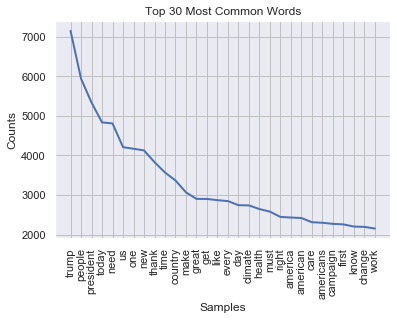

CPU times: user 20 s, sys: 68.8 ms, total: 20 s
Wall time: 20.1 s


In [105]:
%%time
term_freq(candidate_tweets)

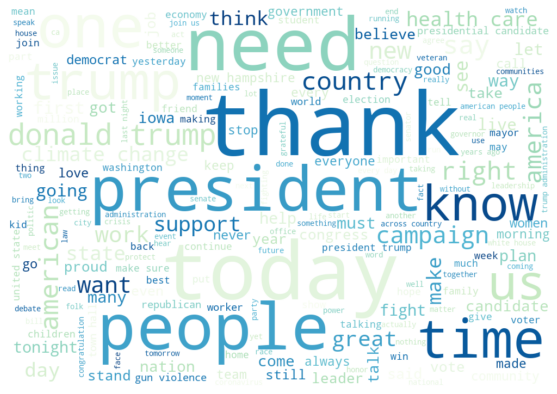

CPU times: user 25.3 s, sys: 511 ms, total: 25.9 s
Wall time: 26.2 s


In [142]:
%%time
get_wc(candidate_tweets)

## Non-Candidate Tweets: Term Frequency

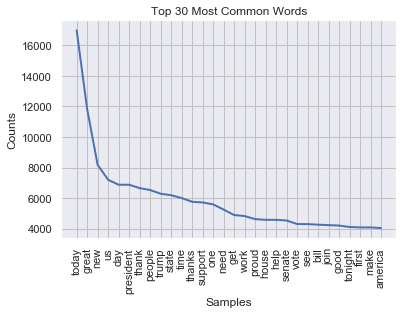

CPU times: user 46.3 s, sys: 1.02 s, total: 47.3 s
Wall time: 51 s


In [143]:
%%time
term_freq(noncandidate_tweets)

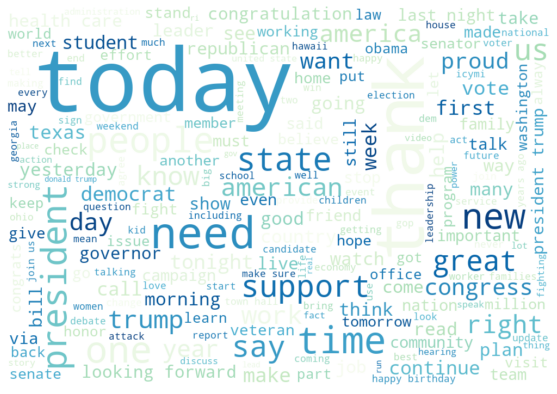

CPU times: user 54.4 s, sys: 1.58 s, total: 56 s
Wall time: 59.5 s


In [144]:
%%time
get_wc(noncandidate_tweets)

Term frequency distributions show a stark contrast between candidate and non-candidate tweets. The former shows a far smoother inflection in its term frequency distribution, whereas the latter exhibits a steep drop off in counts within the top three words. 

Candidate tweets contain the following high-frequency terms in higher proportions than non-candidate tweets:
* today | trump | people | president | new | us | need | great

Non-candidate tweets contain the following words in greater proportion:
* support | vote | proud

Takeaway: very few top terms really distinguish candidates and non-candidates. Similar top terms are used by both. Distinction between classes may come via common function words (i.e. some stopwords) and patterns of less frequent words.

## Candidate Tweets: Sentiment

In [205]:
def get_sentiment(score):
    """Utility function to classify sentiment of passed tweet 
        using textblob's sentiment method 
    
    Arguments:
        scores {[float]} -- [Textblob score]
    
    Returns:
        [str] -- [sentiment label]
    """    
    # sentiment labels
    if score > 0:
        return 'pos'
    elif score == 0:
        return 'neu'
    else:
        return 'neg'
def plot_sentiment(scorelist):
    """Barplot of sentiment labels
    
    Arguments:
        scorelist {[list]} -- [list of Textblob scores]        
    """
    sentlist = [get_sentiment(score) for score in scorelist]
    counter = Counter(sentlist)
    labels = counter.keys()
    values = [v / sum(counter.values()) for v in counter.values()]
    labels, values = zip(*sorted(zip(labels,values)))
    indexes = np.arange(len(labels))
    width = 0.5
    plt.barh(indexes, values, width)
    plt.yticks(indexes, labels)
    plt.xlabel('Count')
    plt.title("Sentiment Frequency")

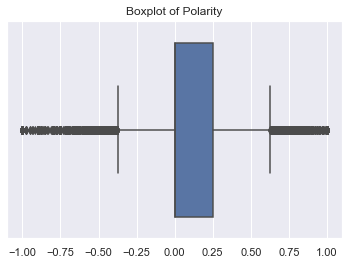

CPU times: user 23.6 s, sys: 845 ms, total: 24.4 s
Wall time: 26.3 s


In [208]:
%%time
from textblob import TextBlob
scorelist = [TextBlob(tweet).sentiment.polarity for tweet in candidate_tweets]
fig, ax = plt.subplots()
sns.boxplot(scorelist, ax=ax).set_title("Boxplot of Polarity")
plt.show()

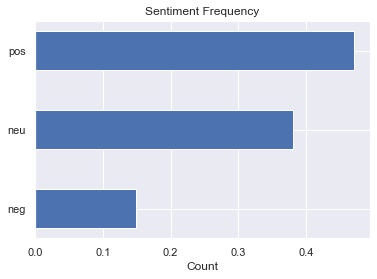

In [209]:
plot_sentiment(scorelist)

## Non-Candidate Tweets: Sentiment

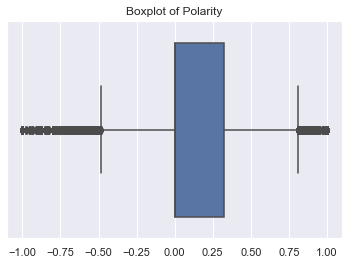

CPU times: user 50.1 s, sys: 1.19 s, total: 51.3 s
Wall time: 55.9 s


In [210]:
%%time
scorelist = [TextBlob(tweet).sentiment.polarity for tweet in noncandidate_tweets]
fig, ax = plt.subplots()
sns.boxplot(scorelist, ax=ax).set_title("Boxplot of Polarity")
plt.show()

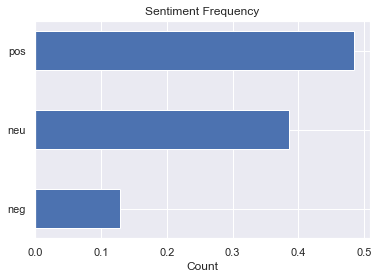

In [211]:
plot_sentiment(scorelist)

The distribution of polarity and proportion of sentiment between candidates and non-candidates were similar with little difference. Non-candidates wrote slightly more positive tweets, and candidates wrote slightly more negative tweets. Overall, there was not much difference.

## Candidate Tweets: Part-of-Speech

In [212]:
from nltk import pos_tag

def get_pos_frequency(documents, title):
    """Function to plot POS frequency
    
    Arguments:
        documents {[list]} -- [list of strings i.e. tweets]
    """    
    wordlist = []
    for document in documents:
        wordlist.extend(word_tokenize(document))
    tagged_words = pos_tag(wordlist)
    numNoun,numVerb,numAdj,numAdv = 0,0,0,0
    for (word, tag) in tagged_words:
        if tag.startswith('N'): numNoun += 1     
        if tag.startswith('V'): numVerb += 1
        if tag.startswith('J'): numAdj += 1
        if tag.startswith('R'): numAdv += 1
    total = sum([numNoun, numVerb, numAdj, numAdv])
    height = [numNoun/total, numVerb/total, numAdj/total, numAdv/total]
    bars = ('Nouns','Verbs','Adjectives','Adverbs')
    y_pos = np.arange(len(bars))
    plt.bar(y_pos, height)
    plt.xticks(y_pos, bars)
    plt.title(title)
    plt.show()

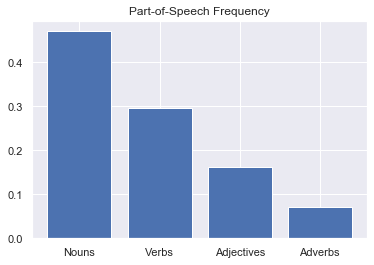

CPU times: user 1min 22s, sys: 1.05 s, total: 1min 23s
Wall time: 1min 26s


In [213]:
%%time
get_pos_frequency(candidate_tweets, "Part-of-Speech Frequency")

## Non-Candidate Tweets: Part-of-Speech

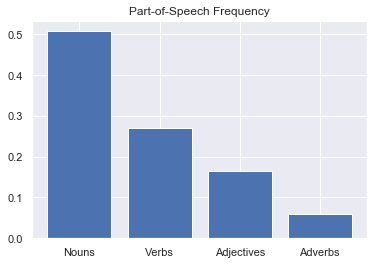

CPU times: user 2min 57s, sys: 3.72 s, total: 3min 1s
Wall time: 3min 19s


In [214]:
%%time
get_pos_frequency(noncandidate_tweets, "Part-of-Speech Frequency")

Overall differences in part-of-speech between candidate and non-candidate tweets appeared negligible. Non-candidate tweets contained more nouns and adjectives, and candidate tweets contained more verbs and adverbs.

## Dendrogram of Users

At an aggregate and without concern for when tweets were created, do the tweets distinguish candidates and non-candidates?

In [190]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as shc


""" define dendrogram label colors based on candidate / non-candidate """
candidates = tweets.loc[tweets[['candidate_2020']].sum(axis = 1) > 0, 'handle'].unique().tolist()#, 'candidate_2016'
noncandidates = tweets.loc[tweets[['candidate_2020']].sum(axis = 1) == 0, 'handle'].unique().tolist()#, 'candidate_2016'
all_users = candidates + noncandidates
label_colors = {}
for user in all_users:
    if user in candidates:
        label_colors[user] = 'g'
    else:
        label_colors[user] = 'r'

def get_dendro(dat):
    """Function to plot dendrogram
    
    Arguments:
        dat {[dataframe]} -- [dataframe containing 'text' by 'handle']
    """        
    handles = dat['handle'].unique().tolist() # unique users        
    usertweets = {} # dictionary of users and concantenate tweet text
    for user in handles:
        usertweets[user] = ' '.join(clean_tweet(text) for text in tweets.loc[tweets['handle'] == user, 'text'])
    tmp = pd.DataFrame(usertweets.items(), columns = ['user','text']).set_index('user')
    token_pattern = re.compile(r'[A-Za-z]+') # custom token pattern of alphabetic words
    cv = CountVectorizer(stop_words=stop_words, token_pattern=token_pattern)
    dtm = cv.fit_transform(tmp['text'])    
    feat_names = cv.get_feature_names()
    print("Vocabulary size: {:d}".format(len(feat_names)))
    doc_names = tmp.index.values 
    data_scaled = normalize(dtm)
    print("Mean feature values: {:.2f}".format(np.mean(data_scaled)))
    plt.figure(figsize=(20,9))
    plt.title("Clustering Dendrogram")
    shc.set_link_color_palette(['r','g'])
    dend = shc.dendrogram(shc.linkage(data_scaled.toarray(), method = 'ward'), labels = doc_names, color_threshold=2, above_threshold_color='grey')
    ax = plt.gca()
    ax.tick_params(axis='x', which='major', labelsize=12)
    xlbls = ax.get_xmajorticklabels()
    for lbl in xlbls:
        lbl.set_color(label_colors[lbl.get_text()])
    plt.show()        

Vocabulary size: 60906
Mean feature values: 0.00


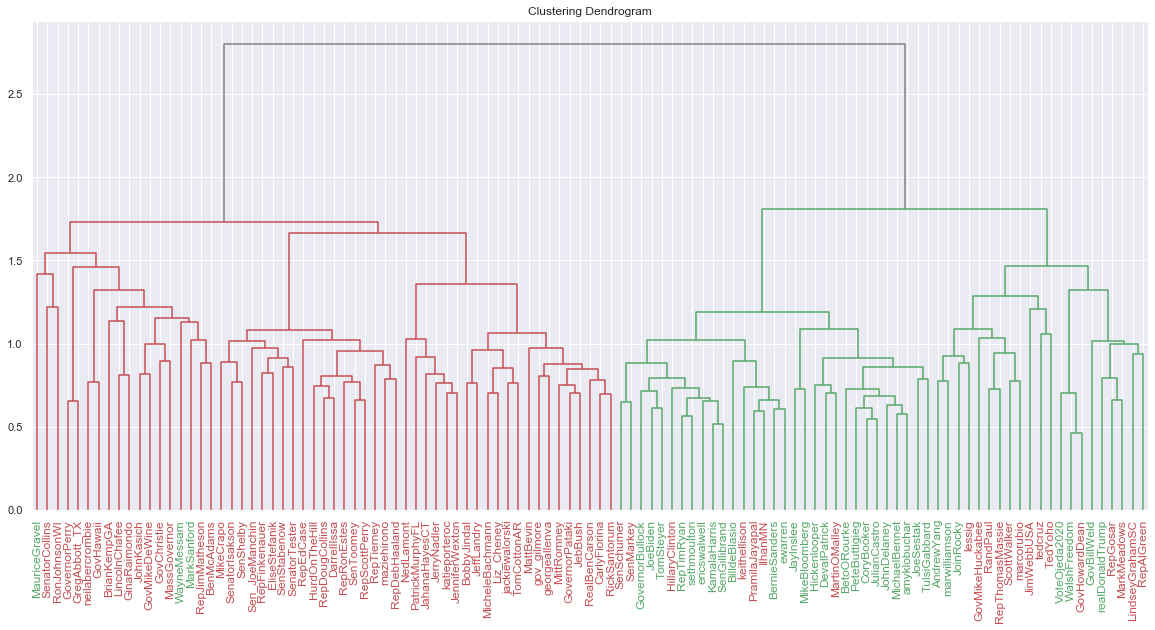

CPU times: user 16.8 s, sys: 459 ms, total: 17.3 s
Wall time: 17.4 s


In [191]:
%%time
get_dendro(tweets)

From an aggregate perspective, tweets from candidates (*red labels*) were mostly clustered together. Likewise, tweets from non-candidates (*black labels*) clustered with other non-candidates for the most part. There were a number of exceptions:

Non-candidates in the candidates cluster:
* SenSchumer
* SenMarky
* HillaryClinton
* Keithellison
* PramilaJayapal
* IlhanMN
* MartinOMalley
* Lessig
* GovMikeHuckabee
* RandPaul
* RepThomasMassie
* ScottWalker
* Marcorubio
* JimWebbUSA
* Tedcruz
* TedYoho
* GovHowardDean
* RepGosar
* MarkMeadows
* LindseyGrahamSC
* RepAlGreen

Candidates in the non-candidates cluster:
* MauriceGravel
* WayneMessam
* MarkSanford

## Top Terms in Each Cluster Using Mean Term Frequency

In [215]:
# create scaled matrix
handles = tweets['handle'].unique().tolist() # unique users        
usertweets = {} # dictionary of users and concantenate tweet text
for user in handles:
    usertweets[user] = ' '.join(clean_tweet(text) for text in tweets.loc[tweets['handle'] == user, 'text'])
tmp = pd.DataFrame(usertweets.items(), columns = ['user','text']).set_index('user')
token_pattern = re.compile(r'[A-Za-z]+') # custom token pattern of alphabetic words
cv = CountVectorizer(stop_words=stop_words, token_pattern=token_pattern)
dtm = cv.fit_transform(tmp['text'])    
feat_names = cv.get_feature_names()
print("Vocabulary size: {:d}".format(len(feat_names)))
doc_names = tmp.index.values 
data_scaled = normalize(dtm)

Vocabulary size: 60906


In [216]:
# create clustering
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
cluster.fit_predict(data_scaled.toarray())

array([0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

In [217]:
labels = np.unique(cluster.labels_)
dfs = []
for label in labels:
    # indices for each cluster
    id_temp = np.where(cluster.labels_ == label)
    # cluster centroid
    x_means = np.mean(data_scaled.toarray()[id_temp], axis = 0)
    # indices of top 10 scores
    sorted_means = np.argsort(x_means)[::-1][:10]
    features = feat_names 
    best_features = [(features[i], x_means[i]) for i in sorted_means]
    best_feature_df = pd.DataFrame(best_features, columns = ['features','score'])
    dfs.append(best_feature_df)
# list of document, label, and cluster
clust_list = list(zip(doc_names, cluster.labels_))

In [218]:
import random

Sample in cluster:

[('WalshFreedom', 0), ('MartinOMalley', 0), ('ewarren', 0), ('BilldeBlasio', 0), ('MarkMeadows', 0)]


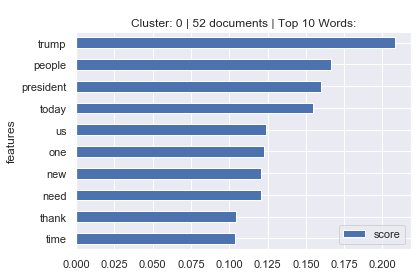

In [220]:
# top words cluster 0
clust = 0
title = "\nCluster: {:d} | {:d} documents | Top 10 Words:".format(clust, sum(cluster.labels_ == clust))
tmp = dfs[clust].sort_values('score')
tmp.plot(
    kind = 'barh', y = 'score', x = 'features', title = title
)
# who in this cluster?
print("Sample in cluster:\n")
print(random.sample([item for item in clust_list if item[1] == clust],5))

Sample in cluster:

[('georgeallenva', 1), ('HurdOnTheHill', 1), ('MittRomney', 1), ('EliseStefanik', 1), ('BenMcAdams', 1)]


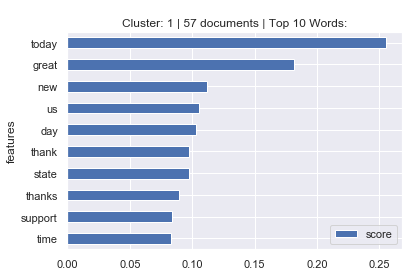

In [221]:
# top words cluster 1
clust = 1
title = "\nCluster: {:d} | {:d} documents | Top 10 Words:".format(clust, sum(cluster.labels_ == clust))
tmp = dfs[clust].sort_values('score')
tmp.plot(
    kind = 'barh', y = 'score', x = 'features', title = title
)
# who in this cluster?
print("Sample in cluster:\n")
print(random.sample([item for item in clust_list if item[1] == clust],5))

## Top Terms that Distinguish Clusters Using F-Statistic on the Mean Difference

In [222]:
import scipy.stats as stats

mydf = pd.DataFrame(data_scaled.toarray(), columns = feat_names, index = doc_names)
scores = []
for column in mydf:    
    data_0 = mydf.loc[cluster.labels_ == 0, column]
    data_1 = mydf.loc[cluster.labels_ == 1, column]
    fvalue, pvalue = stats.f_oneway(data_0, data_1)
    scores.append(fvalue)

In [223]:
# indices of top 10 scores
sorted_scores = np.argsort(scores)[::-1][:10]
features = feat_names 
best_features = [(features[i], scores[i]) for i in sorted_scores]
best_feature_df = pd.DataFrame(best_features, columns = ['features','score']).sort_values('score')

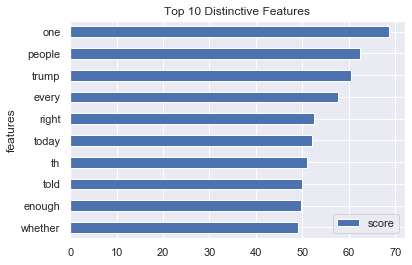

In [224]:
best_feature_df.plot(
    kind = 'barh', y = 'score', x = 'features', title = "Top 10 Distinctive Features"
)